# Investigation of a Linear Tail Artifact in a Graph of COVID-19 Deaths fro the CDC

Through 2020Q2, the CDC has been tracking the total number of deaths in the US that were "confirmed or presumed COVID-19". The raw data of weekly deaths is accessible in table form here (though it is subject to change retroactively, which is ultimately the point of this lab):

https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm

When plotted, the CDC's data looks like this:

![CDC Official Provisional Count of COVID-19 Deaths Per Week](cdc-graph-image.jpg)

## Observed Anomaly

The almost perfectly linear decline since mid-April (conveniently sloped to reach 0 exactly next week -- presumably whichever week you look at it, per the Copernican Principle) is truly bizarre, and clearly an artifact resulting from some kind of bias. However, most forms of bias introduce errors *proportional to* the phenomenon being measured, which would, when graphed, still depict a geometric curve -- perhaps compressed or inflated or offset, but nonetheless geometric. A bias that introduces a perfect linear tail in the temporal domain like that is truly unusual. 

## Hypothesis

It's my belief that the linear tail is being caused by a reporting bottleneck at the CDC. That is, I believe there's some desk out there that can only record X number of cases per week, and does so with a random sampling of the cases in the backlog. The purpose of this lab is to model such a bottleneck and see if it generates a graph with a linear tail like the one seen.

### Provisional support for hypothesis.

I had conjectured earlier that, if the CDC had a fixed-rate processing bottleneck for an exponentially growing backlog of death reports, then we'd see the start of the linear downslope advancing forward in time at a rate slower than the passage of actual time. An examination of the CDC's table with the help of the Wayback Machine confirms that this is the case.

According to the reported totals as of May 3, the peak of weekly deaths occurred on 4/11, with 12,262 deaths provisionally reported in that week. [WayBack Machine snapshot 2020-05-03](https://web.archive.org/web/20200503223517/https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm)

It wasn't until May 24, three weeks later, that the reported peak advanced by one week, to 4/18, with 15,311 deaths provisionally reported in that week. By that time, the 4/11 total had climbed to 15,031. [Wayback Machine snapshot 2020-05-24](https://web.archive.org/web/20200524200037/https://www.cdc.gov/nchs/nvss/vsrr/covid19/index.htm)

So it does appear that, according to the historical data, there is a growing backlog of reports that are being processed at a constant rate.

## Setup

Let's get our tools in order first.

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

In [37]:
# Create a date range that we'll use for all our subsequent experiments.
# This date range is inspired by the CDC's actual data.

daterange = pd.date_range(start='2/1/2020', end='7/1/2020', freq='7D')
daterange

DatetimeIndex(['2020-02-01', '2020-02-08', '2020-02-15', '2020-02-22',
               '2020-02-29', '2020-03-07', '2020-03-14', '2020-03-21',
               '2020-03-28', '2020-04-04', '2020-04-11', '2020-04-18',
               '2020-04-25', '2020-05-02', '2020-05-09', '2020-05-16',
               '2020-05-23', '2020-05-30', '2020-06-06', '2020-06-13',
               '2020-06-20', '2020-06-27'],
              dtype='datetime64[ns]', freq='7D')

In [38]:
# Create a data frame using the time series as an index.

df_init = pd.DataFrame({'date': daterange}).set_index('date')
df_init.dtypes

Series([], dtype: object)

In [62]:
# Create a simulated spread of a disease through a population.

# We'll say that, each week, the disease kills growthrate times as many people
# as it had killed the week before.

# We'll also say that the growth rate diminishes every week because of mitigation
# measures. This appears to approximately model actual real-world behavior.

# According to the CDC's data, on 2/22/2020 (week 3), 5 people died. 
# Then, in the week of 4/4/2020 (week 9), 9,516 people died. This implies
# a weekly growth factor of about 3.5.

growthrate = 3.9
num_deaths_occurred_this_week = [0] * len(daterange)
num_deaths_occurred_this_week[3] = 5

# The growth from 4/4 to 4/11 was only 15,712/9,516 = 1.65
# For the growth rate to be dropping from an initial 3.5 in week 3
# to 1.65 in week 10, that means it's dropping by about 0.23 every week.

for i in range(4, len(daterange)):
    # Yes, I can do this parametrically, but I feel like this approach is more "direct".
    # That is, it leaves less room for me to screw up on the off chance that a brainfart
    # results in my temporary inability to do 7th-grade math.
    lastweek_deathcount = num_deaths_occurred_this_week[i - 1]
    num_deaths_occurred_this_week[i] = int(lastweek_deathcount * growthrate)
    
    # The growthrate declines due to mitigation measures
    growthrate -= 0.23

df_init['num_deaths_occurred_this_week'] = num_deaths_occurred_this_week
df_init

,num_deaths_occurred_this_week
date,
2020-02-01,0
2020-02-08,0
2020-02-15,0
2020-02-22,5
2020-02-29,19
2020-03-07,69
2020-03-14,237
2020-03-21,760
2020-03-28,2264


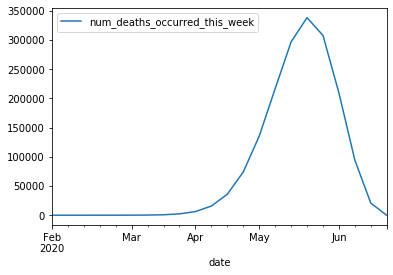

In [63]:
# Get our plotting tools in order.
# We should see a nice smooth geometric curve.
import matplotlib.pyplot as plt
%matplotlib inline

df_init.plot()
plt.show()

In [6]:
# One last thing. Let's import some libraries we'll rely on during our experiments.

import random
from datetime import timedelta


# Experiment 1 (Controls): Delays of 6-8 weeks

The first thing I'd like to do is to rule out the conjecture that reports are simply being delayed by "up to 6 to 8 weeks" (which really just means being delayed by 0 to 8 weeks). That's the claim made on the CDC website, but I don't believe that it adequately explains the linear downslope for a number of reasons. Chief among them is the fact that the downlope starts 11 weeks in the past as of the time of this writing!

In [7]:
df_experiment = df_init.copy()

## Experiment 1.a.: A uniform distribution from 0 to 8 weeks

The claim of being "delayed up up to 6 to 8 weeks" can mean many things. The simplest thing I think it means is that there's a uniform reporting delay applied to each report; the report can be submitted immediately, or it can be stalled by up to 8 weeks. (I believe they say "6 to 8 weeks" on the website in order to placate impatient human users and to emphasize to laymen readers the uncertainty in the reporting.) In this model, a delay of more than 8 weeks is impossible. Let's see what happens.

In [31]:
# We're going to do a total dumb brute-force approach and just iterate through every damn death!
# We've picked seed and growth numbers that are small enough for this to be a feasible approach.

df_experiment['deaths_reported_after_uniform_8wk_delay'] = 0

last_date = df_experiment.index[-1]

def report_deaths_with_uniform_distributed_8week_delay(row):
    # The "name" field of a row object is how we get its index value.
    rowdate = row.name
    
    deathcount = row['num_deaths_occurred_this_week']
    for i in range(deathcount):
        weeks_reporting_delay = random.randint(0, 8)
        date_reporting = rowdate + timedelta(weeks_reporting_delay * 7)
        if date_reporting > last_date:
            # This death won't be reported within the timeframe that we're modeling.
            # It occurred within the timeframe, but it won't be reported unti "the future".
            continue
            
        df_experiment.loc[rowdate, 'deaths_reported_after_uniform_8wk_delay'] += 1
        
        
df_experiment.apply(report_deaths_with_uniform_distributed_8week_delay, axis=1)
df_experiment.describe()

,num_deaths_occurred_this_week,deaths_counted,deaths_uncounted,deaths_reported_after_uniform_8wk_delay
count,27.000000,27.000000,27.00000,27.000000
mean,7495.296296,575.666667,6919.62963,2773.111111
std,14289.292494,498.443809,14251.01044,3472.378029
min,10.000000,10.000000,0.00000,10.000000
25%,84.000000,84.000000,0.00000,84.000000
50%,730.000000,514.000000,0.00000,730.000000
75%,6583.000000,1018.000000,5426.50000,5444.500000
max,57819.000000,1395.000000,57510.00000,9781.000000


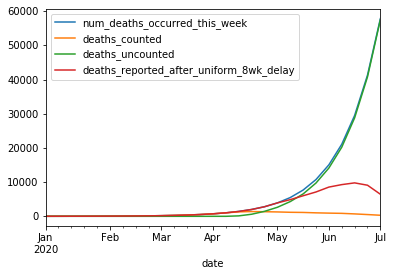

In [32]:
df_experiment.plot()
plt.show()

### Results

As we can see, a simple reporting delay, in which each death is reported late by a random amount from anywhere from 0 to 8 weeks on a uniform distribution, doesn't produce a linear tail. It just creates an illusion of a right-shifted curve, but doesn't change its shape. 

## Experiment 1.b.: Gaussian delay of "up to 6 to 8 weeks"

Here we assume that the claim of "may be delayed up to 6 to 8 weeks" means that the *average* delay is 4 weeks, *one* standard deviation is 6 weeks, *two* standard deviations is 8 weeks, and so on. This seems a little more believable than a flat uniform delay. In the strictest sense, it means that only 95% of reports are delivered within 8 weeks, so 5% of reports are actually delayed *more than* 8 weeks, which lays false the claim that reports are delayed "up to" 8 weeks -- but I'm sure the CDC would consider this observation to be a mere quibble.

In [10]:
df_experiment['deaths_reported_after_gaussian_delay'] = 0

def deaths_reported_after_gaussian_delay(row):
    # The "name" field of a row object is how we get its index value.
    rowdate = row.name
    
    deathcount = row['num_deaths_occurred_this_week']
    for i in range(deathcount):
        weeks_reporting_delay = int(max(0, random.gauss(4, 2)))
        date_reporting = rowdate + timedelta(weeks_reporting_delay * 7)
        
        try:
            row_reporting = df_experiment.loc[date_reporting]
        except KeyError:
            # This death won't be reported within the timeframe that we're modeling.
            # It occurred within the timeframe, but it won't be reported unti "the future".
            continue
            
        row_reporting['deaths_reported_after_gaussian_delay'] += 1
        
        
df_experiment.apply(deaths_reported_after_gaussian_delay, axis=1)
df_experiment.describe()

,num_deaths_occurred_this_week,deaths_reported_after_uniform_8wk_delay,deaths_reported_after_gaussian_delay
count,27.000000,27.00000,27.000000
mean,7495.296296,2770.37037,2793.444444
std,14289.292494,5278.55295,5313.881642
min,10.000000,0.00000,0.000000
25%,84.000000,31.50000,29.500000
50%,730.000000,266.00000,268.000000
75%,6583.000000,2409.50000,2460.000000
max,57819.000000,21446.00000,21574.000000


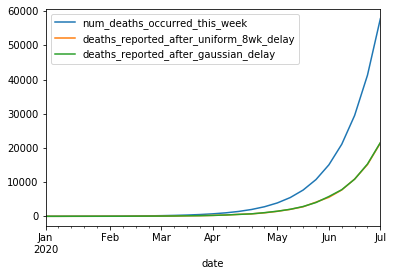

In [11]:
df_experiment.plot()
plt.show()

### Results

Clearly, the use of a Gaussian rather than uniform distribution has no effect on the shape of the curve.

## Experiment 1.c.: A fixed delay of 8 weeks

What if we interpret is in the most braindead way possible: the reports get filed after a fixed delay of 8 weeks? It's pretty obvious why that's not the case.

In [12]:
df_experiment['deaths_reported_after_fixed_8wk'] = 0

def deaths_reported_after_fixed_8wk(row):
    # The "name" field of a row object is how we get its index value.
    rowdate = row.name
    
    deathcount = row['num_deaths_occurred_this_week']
    for i in range(deathcount):
        weeks_reporting_delay = 8
        date_reporting = rowdate + timedelta(weeks_reporting_delay * 7)
        
        try:
            row_reporting = df_experiment.loc[date_reporting]
        except KeyError:
            # This death won't be reported within the timeframe that we're modeling.
            # It occurred within the timeframe, but it won't be reported unti "the future".
            continue
            
        row_reporting['deaths_reported_after_fixed_8wk'] += 1
        
        
df_experiment.apply(deaths_reported_after_fixed_8wk, axis=1)
df_experiment.describe()

,num_deaths_occurred_this_week,deaths_reported_after_uniform_8wk_delay,deaths_reported_after_gaussian_delay,deaths_reported_after_fixed_8wk
count,27.000000,27.00000,27.000000,27.000000
mean,7495.296296,2770.37037,2793.444444,507.851852
std,14289.292494,5278.55295,5313.881642,968.941997
min,10.000000,0.00000,0.000000,0.000000
25%,84.000000,31.50000,29.500000,0.000000
50%,730.000000,266.00000,268.000000,50.000000
75%,6583.000000,2409.50000,2460.000000,447.500000
max,57819.000000,21446.00000,21574.000000,3919.000000


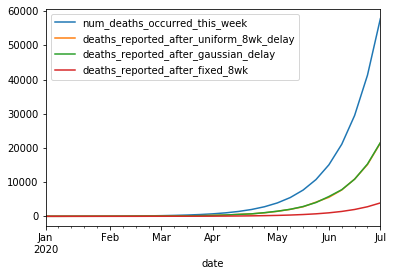

In [13]:
df_experiment.plot()
plt.show()

### Results

As we can see, all that did was shift the curve to the right by 8 weeks, exactly as expected.

# Experiment 2 (Proof-of-concept): Reporting Bottleneck with FIFO Processing

What if the CDC could only receive and process a fixed number of death reports per week? And what if they processed those reports in the order they received them, as quickly as they could?

In [14]:
df_experiment = df_init.copy()

In [15]:
# We'll need a const variable to describe the max number of reports that the CDC 
# can perform in any given week.

WEEKLY_PROCESSING_CAPACITY = 3000

In [16]:
# Model the CDC's processing of reports every week.
# Every week, they go through the collection of deaths that haven't been processed yet,
# and process as many as they can, in the order they've been received, up to a max
# of BOTTLENECK for that week.

df_experiment['deaths_counted'] = 0
df_experiment['deaths_uncounted'] = df_experiment['num_deaths_occurred_this_week']

# Because we need to rigidly enforce the order in which this processing takes place,
# we're gonna use some terrible antipatterns here. Do not try this at home!

for rowdate, row in df_experiment.iterrows():
    processing_capacity_remaining = WEEKLY_PROCESSING_CAPACITY

    for rowtocountdate, rowtocount in df_experiment.iterrows():
        if processing_capacity_remaining <= 0:
            # Can't process any more deaths this week.
            break

        if rowtocountdate > rowdate:
            # Can't count rows that haven't happened yet!
            break
        
        deaths_uncounted = rowtocount['deaths_uncounted']
        if deaths_uncounted <= 0:
            # No uncounted deaths to read from this row.
            # Skip to the next one
            continue
        
        deaths_counted_now = min(deaths_uncounted, processing_capacity_remaining)
        
        processing_capacity_remaining -= deaths_counted_now
        df_experiment.loc[rowtocountdate, 'deaths_uncounted'] -= deaths_counted_now
        df_experiment.loc[rowtocountdate, 'deaths_counted'] += deaths_counted_now
        
        print(f'{rowdate.strftime("%Y-%m-%d")}: Counting {deaths_counted_now} of {deaths_uncounted} uncounted deaths from {rowtocountdate.strftime("%Y-%m-%d")}')
    

2020-01-01: Counting 10 of 10 uncounted deaths from 2020-01-01
2020-01-08: Counting 14 of 14 uncounted deaths from 2020-01-08
2020-01-15: Counting 19 of 19 uncounted deaths from 2020-01-15
2020-01-22: Counting 26 of 26 uncounted deaths from 2020-01-22
2020-01-29: Counting 36 of 36 uncounted deaths from 2020-01-29
2020-02-05: Counting 50 of 50 uncounted deaths from 2020-02-05
2020-02-12: Counting 70 of 70 uncounted deaths from 2020-02-12
2020-02-19: Counting 98 of 98 uncounted deaths from 2020-02-19
2020-02-26: Counting 137 of 137 uncounted deaths from 2020-02-26
2020-03-04: Counting 191 of 191 uncounted deaths from 2020-03-04
2020-03-11: Counting 267 of 267 uncounted deaths from 2020-03-11
2020-03-18: Counting 373 of 373 uncounted deaths from 2020-03-18
2020-03-25: Counting 522 of 522 uncounted deaths from 2020-03-25
2020-04-01: Counting 730 of 730 uncounted deaths from 2020-04-01
2020-04-08: Counting 1021 of 1021 uncounted deaths from 2020-04-08
2020-04-15: Counting 1429 of 1429 uncou

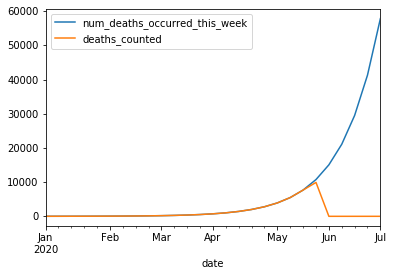

In [17]:
df_experiment[['num_deaths_occurred_this_week', 'deaths_counted']].plot()
plt.show()

### Results

As expected, the reported death count keeps up with the actual death count until such time as it exceeds the weekly processing capacity. At that point, the current death count is aliased across a span of one week. That is, it can report the full total of one week and the partial total of the following week, and all subsequent weeks are zero.

In the original graph, we do not see this behavior. That is, we don't see a peak one week, a partial count the following week, and zeroes for all remaining weeks. We see a smooth line from the peak to the present. This probably means that the bottleneck is not processing its backlog in FIFO order, but at random.

# Experiment 3 (Hypothesis Test): Reporting Bottleneck with Uniform Random Processing

What if the CDC could only receive and process a fixed number of death reports per week, as before?And what if they processed them as quickly as they could, as before? But instead of processing them in the order they receive them, they draw randomly from all outstanding reports available?

In [25]:
df_experiment = df_init.copy()
WEEKLY_PROCESSING_CAPACITY = 1000

In [26]:
df_experiment['deaths_counted'] = 0
df_experiment['deaths_uncounted'] = df_experiment['num_deaths_occurred_this_week']

total_deaths_counted = 0
for rowdate, row in df_experiment.iterrows():
    print(f'Simulating CDC desk processing on {rowdate.strftime("%Y-%m-%d")}')

    # We're gonna use a horribly memory inefficient technique for drawing dates,
    # because Python lets us and I can't be bothered with dealing with scikit right now.
    date_candidates = []
    
    for rowtocountdate, rowtocount in df_experiment.iterrows():
        if rowtocountdate > rowdate:
            # Can't count rows that haven't happened yet!
            break
        deaths_uncounted = rowtocount['deaths_uncounted']
        if deaths_uncounted <= 0:
            continue
            
        da = [rowtocountdate] * deaths_uncounted
        date_candidates += da
                
    # Draw from the candidate dates according to weight, without replacement,
    # where "weight" is the number of uncounted reports on that date.
    num_to_draw = min(WEEKLY_PROCESSING_CAPACITY, len(date_candidates))
    death_dates_drawn = random.sample(date_candidates, num_to_draw)

    for death_date in death_dates_drawn:
        total_deaths_counted += 1
        df_experiment.loc[death_date, 'deaths_counted'] += 1
        df_experiment.loc[death_date, 'deaths_uncounted'] -= 1
    
print(f'Total deaths counted: {total_deaths_counted}')

Simulating CDC desk processing on 2020-01-01
Simulating CDC desk processing on 2020-01-08
Simulating CDC desk processing on 2020-01-15
Simulating CDC desk processing on 2020-01-22
Simulating CDC desk processing on 2020-01-29
Simulating CDC desk processing on 2020-02-05
Simulating CDC desk processing on 2020-02-12
Simulating CDC desk processing on 2020-02-19
Simulating CDC desk processing on 2020-02-26
Simulating CDC desk processing on 2020-03-04
Simulating CDC desk processing on 2020-03-11
Simulating CDC desk processing on 2020-03-18
Simulating CDC desk processing on 2020-03-25
Simulating CDC desk processing on 2020-04-01
Simulating CDC desk processing on 2020-04-08
Simulating CDC desk processing on 2020-04-15
Simulating CDC desk processing on 2020-04-22
Simulating CDC desk processing on 2020-04-29
Simulating CDC desk processing on 2020-05-06
Simulating CDC desk processing on 2020-05-13
Simulating CDC desk processing on 2020-05-20
Simulating CDC desk processing on 2020-05-27
Simulating

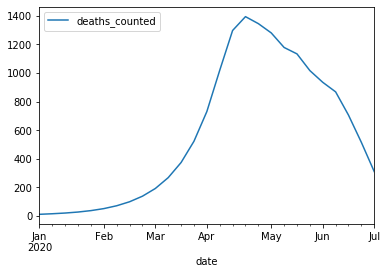

In [27]:
df_experiment[['deaths_counted']].plot()
plt.show()

### Results

BOOM! *That* looks like the original graph! A smooth exponential growth curve makes a bend at its peak, resembling a Gaussian normal curve, and then flattens out into a linear downsloping tail